In [1]:
!pip install --quiet jax jaxlib igraph matplotlib scikit-learn umap-learn

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
from sergio import SergioJAX
import matplotlib.pyplot as plt
from util import scale_free_graph

In [4]:
rng, subrng = jax.random.split(jax.random.PRNGKey(42))

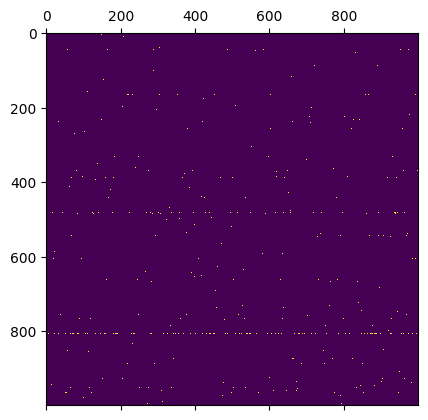

In [5]:
n_genes = 1000
n_cell_types = 10
n_sc = 150
graph = scale_free_graph(subrng, n_genes)
plt.matshow(graph)

In [6]:
# random / noise parameters
noise_amplitude = 1.0
noise_type = "dpd"
decays = 0.8

In [7]:
sim = SergioJAX(
    n_genes=n_genes,
    n_cell_types=n_cell_types,
    n_sc=n_sc,
    noise_amplitude=noise_amplitude,
    noise_type=noise_type,
    decays=decays,
)

In [8]:
rng, subrng = jax.random.split(rng)
# sample random contribution between 1 and 5
_k = jax.random.uniform(rng, minval=1.0, maxval=5.0, shape=(n_genes, n_genes))

# sample random sign (repressing or activating)
rng, subrng1, subrng2 = jax.random.split(rng, 3)
sign = jax.random.bernoulli(subrng1,
                            jax.random.beta(
                                subrng2, a=.5, b=.5, shape=(n_genes, n_genes)),
                            shape=(n_genes, n_genes)) * 2 - 1
k = sign * _k
# go from [n_genes, n_genes] to [n_cell_types, n_genes, n_genes]
k = k[None].repeat(n_cell_types, 0)

# sample random basal rates
rng, subrng = jax.random.split(rng)
# sample random contribution between 1 and 5
basal_rates = jax.random.uniform(rng,
                                 minval=1.0,
                                 maxval=5.0,
                                 shape=(n_cell_types, n_genes))
# hill constant
hill = 2.0

In [9]:
# prepare simulation
sim.custom_graph(
    graph,
    k,
    basal_rates,
    hill,
)

In [10]:
add_outlier_effect = True
add_lib_size_effect = True
add_dropout_effect = True

In [11]:
rng, subrng = jax.random.split(rng)

# first simulate
sim.simulate(rng=subrng)

# Get the clean simulated expression matrix after steady_state simulations
# shape: [number_bins (#cell types), number_genes, number_sc (#cells per type)]
rng, subrng = jax.random.split(rng)
expr = sim.getExpressions(rng=subrng)

# add technical noise (assume 1 experimental setting for wild type and KO experiments)
# 1) outlier genes
if add_outlier_effect:
    rng, subrng = jax.random.split(rng)
    expr = sim.outlier_effect(subrng,
                              expr,
                              outlier_prob=0.01,
                              mean=0.8,
                              scale=1.0)

# 2) library size
if add_lib_size_effect:
    rng, subrng = jax.random.split(rng)
    _, expr = sim.lib_size_effect(subrng,
                                  expr,
                                  mean=7.0,
                                  scale=0.4)

# 3) dropout
if add_dropout_effect:
    rng, subrng = jax.random.split(rng)
    binary_ind = sim.dropout_indicator(subrng,
                                       expr,
                                       shape=8,
                                       percentile=80)
    expr = binary_ind * expr

# 4) mRNA count data
rng, subrng = jax.random.split(rng)
# [n_cell_types, n_genes, n_sc]
expr = sim.convert_to_UMIcounts(subrng, expr)

In [12]:
expr.shape

(10, 1000, 150)

In [ ]:
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [14]:
# flatten to get 2D matrix of [all_cells, n_genes]
flattened = expr.transpose((2, 0, 1)).reshape(-1, n_genes)

In [15]:
scaler = StandardScaler(with_mean=True, with_std=True).fit(flattened)
pca = PCA(n_components=50,random_state=123).fit(scaler.transform(flattened))
emb_pc = pca.transform(scaler.transform(flattened))

model_umap = umap.UMAP(n_components=2, random_state=123).fit(emb_pc)

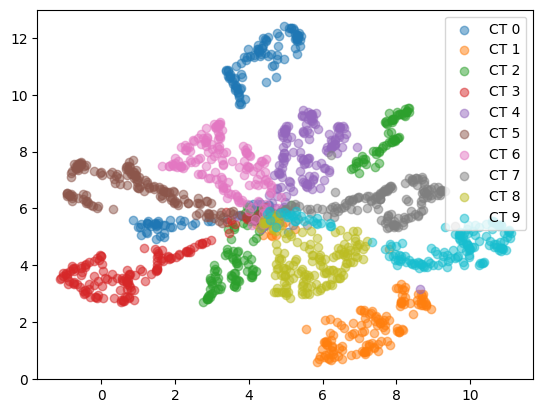

In [16]:
for i in range(n_cell_types):
    _data = expr[i].transpose((1, 0))
    _data = scaler.transform(_data)
    _data = pca.transform(_data)
    _data = model_umap.transform(_data)
    plt.scatter(_data[:, 0], _data[:, 1], alpha=0.5, label=f"CT {i}")
plt.legend()